In [1]:
import numpy as np
import h5py
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az
import ringdown as rd

from pyRing import pyRing
from pyRing import likelihood
from pyRing import noise

from tqdm import tqdm

/work/yifan.wang/more_ringdown/runs/ringdown-runs/env-numpyro/lib/python3.7/site-packages/pyRing/utils.py:15: UserWarning: surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.
  warnings.warn("surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.")


In [2]:
fit = rd.Fit(model='mchi_aligned')
fit.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_fit.nc')

In [3]:
# stacking the posterior h_det and parameters
hs = fit.result.posterior.h_det.stack(samples=('chain', 'draw'))
A = fit.result.posterior.A.stack(samples=('chain','draw'))
phi = fit.result.posterior.phi.stack(samples=('chain','draw'))
M = fit.result.posterior.M.stack(samples=('chain','draw'))
chi = fit.result.posterior.chi.stack(samples=('chain','draw'))

# Read in the data

In [4]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = rd.Data(h, index=t0 + dt*np.arange(len(h)), ifo=dname)
        
        return raw_strain

ifos = ['H1', 'L1']
input_path = '/work/yifan.wang/ringdown/GW150914/maxisi-data-release/{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}

for s in raw_strain.values():
    fit.add_data(s)
T = 0.2
srate = 2048
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)

# condition data
fit.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)
fit.compute_acfs()

# Run Pyring

In [8]:
import sys,importlib
sys.path.append("/work/yifan.wang/ringdown/GW150914/pyring/gitlab-ringdown-systematics/utils/")
import pyring_par #par by default
from pyring_par import *
import data #fetch_data, pyring_time etc
import wheel #likelihood, compute snr etc

In [9]:
importlib.reload(pyring_par)

<module 'pyring_par' from '/work/yifan.wang/ringdown/GW150914/pyring/gitlab-ringdown-systematics/utils/pyring_par.py'>

In [10]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 2048, 
                'analysis-duration': 0.2, 
                'analysis-duration-n': int(0.2*2048),})
model = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)




##########################
# [Setting the start time #
##########################

Trigtime in H1             : 1126259462.423000

* Warning: To err on the conservative side, when fixing the start time, pyRing selects the discrete sample immediately after the start time requested. This implies that the actual start time used in the analysis can be larger than the one requested up to 0.000488 s, i.e. 1/(sampling_rate). If you wish to reduce this error, please increase the sampling rate and the bandpassing frequency accordingly.



################
# [Data reading #
################


------
- [H1 -
------


* Using GWPY to download data.

Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

* Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.

* Bandpassing the raw strain between [20, 1024] Hz.

* Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8

* Computing the one-sided PSD with the Welch method and th

In [11]:
model

# Local load data

In [12]:
importlib.reload(data)

<module 'data' from '/work/yifan.wang/ringdown/GW150914/pyring/gitlab-ringdown-systematics/utils/data.py'>

In [13]:
pr_data  = {}
pr_time  = {}
for d in model.detectors.keys():
    pr_data[d],pr_time[d] = data.local_load_data(d,**test_par)


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8


# Plot data and waveform template in the same figure

In [14]:
%matplotlib inline
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'legend.frameon': True,
          'legend.loc': 'best',
          'lines.markersize' : 14,
          'figure.figsize': fig_size}
mpl.rcParams.update(params)

In [15]:
rd_data = {}
for d in ['H1','L1']:
    rd_data[d] = fit.data[d]
    rd_data[d] = rd_data[d][(rd_data[d].index >= model.detectors['H1'].time[0]) \
                            & (rd_data[d].index <= model.detectors['H1'].time[-1])]

In [16]:
rdmfsnr = fit.compute_posterior_snrs(optimal=False)
i = np.argmax(rdmfsnr)
prefactor = np.sqrt(16*np.pi/5)
pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}

In [17]:
np.max(rdmfsnr)

13.426541339972433

In [18]:
pyring_par

{'Mf': array(72.84400244),
 'af': array(0.72848178),
 'A2220': 5.595449455544791,
 'A2221': 6.457081321435618,
 'phi2220': -0.9737754582321143,
 'phi2221': 1.652119726595113}

In [19]:
importlib.reload(wheel)
#This step is for computing waveform, PyRing doesn't output a waveform
result = wheel.wheel(model)

In [20]:
wf_time, wf = result.get_hstrain(pyring_par,pr_time)

In [21]:
crop_time, crop_data = result.get_data(pr_time,pr_data)

# Plot the data and waveform

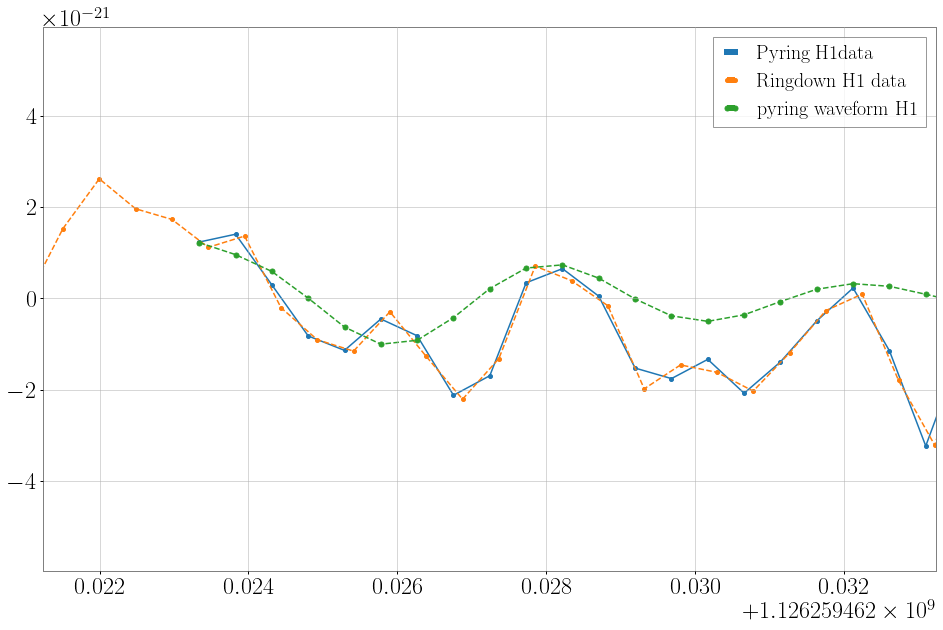

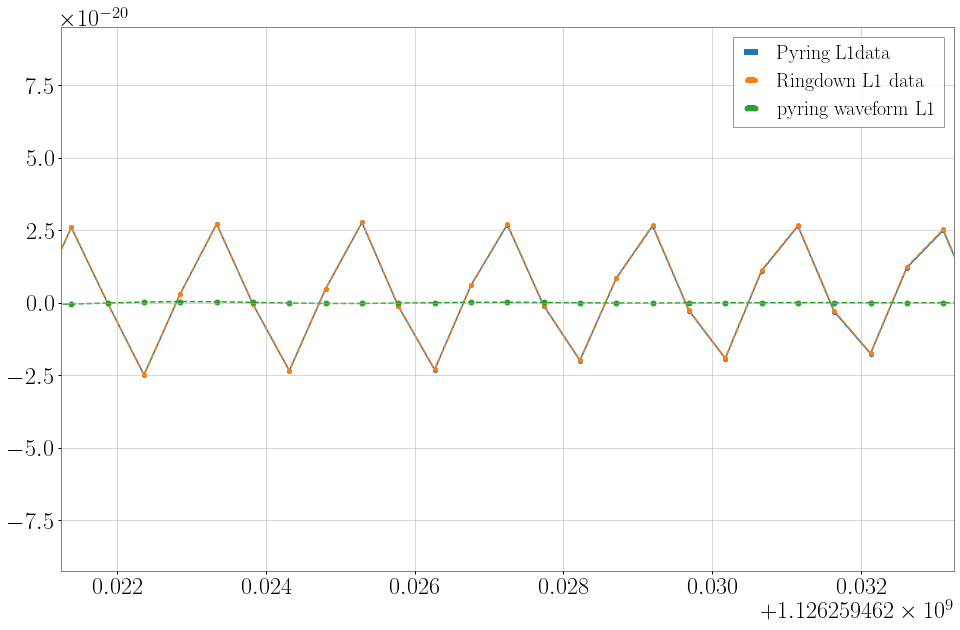

In [22]:
for d in model.detectors.keys():
    plt.figure(figsize=[16,10])
    
    #plot data
    plt.plot(crop_time[d],crop_data[d],marker='o',ms=4,label='Pyring '+str(d)+'data')
    plt.plot(rd_data[d].index,rd_data[d],ls='--',marker='o',ms=4,label='Ringdown '+str(d)+' data')

    #plot waveform   
    plt.plot(wf_time[d],wf[d],
             ls='--',marker='o',ms=5,label='pyring waveform '+str(d))
    if d == 'H1':
        hsi=0
    else:
        hsi=1
    #plt.plot(fit.analysis_data[d].index,hs[hsi,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='Ringdown h_det '+str(d))
    
    middle = model.detectors[d].time[len(model.detectors[d].time)//2]
    plt.xlim(middle-0.002,middle+0.01)
    plt.legend()

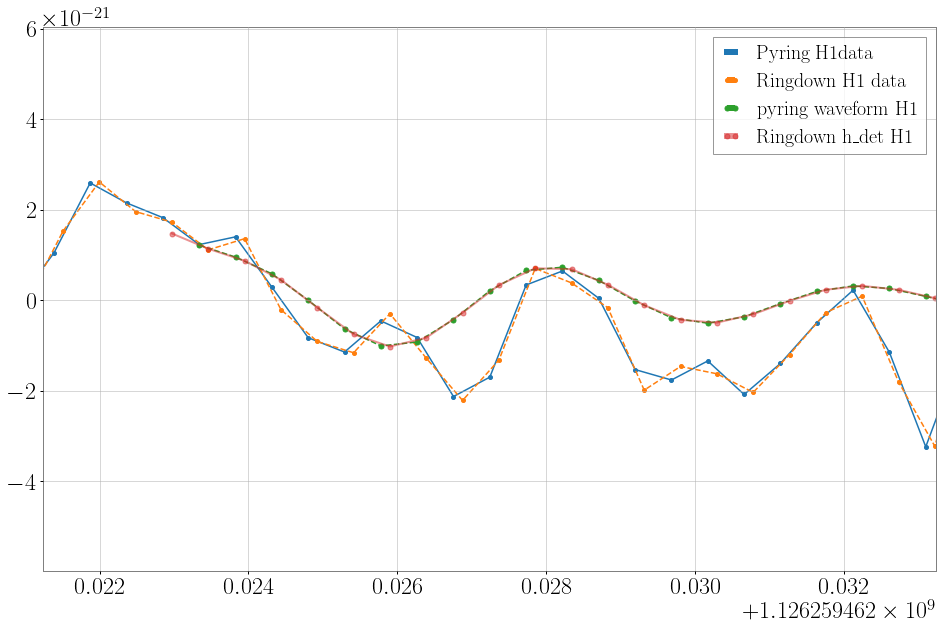

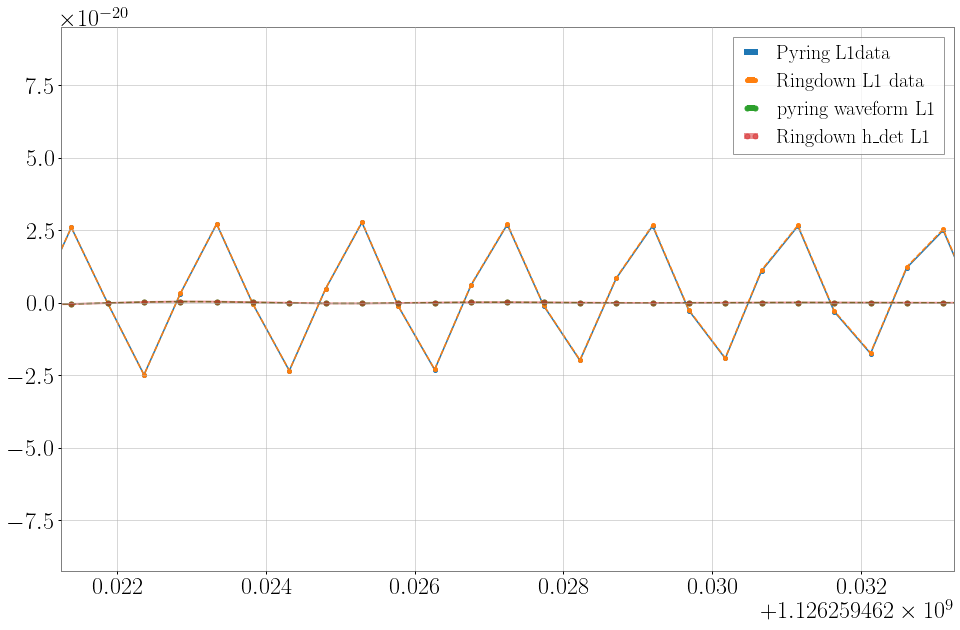

In [23]:
for d in model.detectors.keys():
    plt.figure(figsize=[16,10])
    
    #plot data
    plt.plot(pr_time[d],pr_data[d],marker='o',ms=4,label='Pyring '+str(d)+'data')
    plt.plot(rd_data[d].index,rd_data[d],ls='--',marker='o',ms=4,label='Ringdown '+str(d)+' data')

    #plot waveform   
    plt.plot(wf_time[d],wf[d],
             ls='--',marker='o',ms=5,label='pyring waveform '+str(d))
    if d == 'H1':
        hsi=0
    else:
        hsi=1
    plt.plot(fit.analysis_data[d].index,hs[hsi,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='Ringdown h_det '+str(d))
    
    middle = model.detectors[d].time[len(model.detectors[d].time)//2]
    plt.xlim(middle-0.002,middle+0.01)
    plt.legend()

PyRing data and pyring waveform and maxisi's ringdown waveform and data. Seems consistent

In [24]:
fit.analysis_data['H1'].index[0]

1126259462.4229736

In [25]:
wf_time['H1'][0]

1126259462.4233398

In [26]:
np.sqrt(2 * (model.log_likelihood(pyring_par) - model.logZnoise))

12.522362315152748

# Matched-filter and Optimal SNR comparison

In [27]:
prmf = result.mfsnr(pyring_par,pr_time,pr_data,network=True)
propt = result.optsnr(pyring_par,pr_time,network=True)

In [28]:
prmf,propt

(13.573830690387627, 12.789947764796873)

In [29]:
pr_optsnr_net,pr_mfsnr_net = wheel.compute_multiple_snr(
    model,pr_time,pr_data,M,chi,A,phi,network=True,acf_from_psd=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [05:25<00:00, 12.28it/s]


In [30]:
rd_optsnr = fit.compute_posterior_snrs(optimal=True,network=True)
rd_mfsnr = fit.compute_posterior_snrs(optimal=False,network=True)
rd_optsnr_nonet = fit.compute_posterior_snrs(optimal=True,network=False)
rd_mfsnr_nonet = fit.compute_posterior_snrs(optimal=False,network=False)

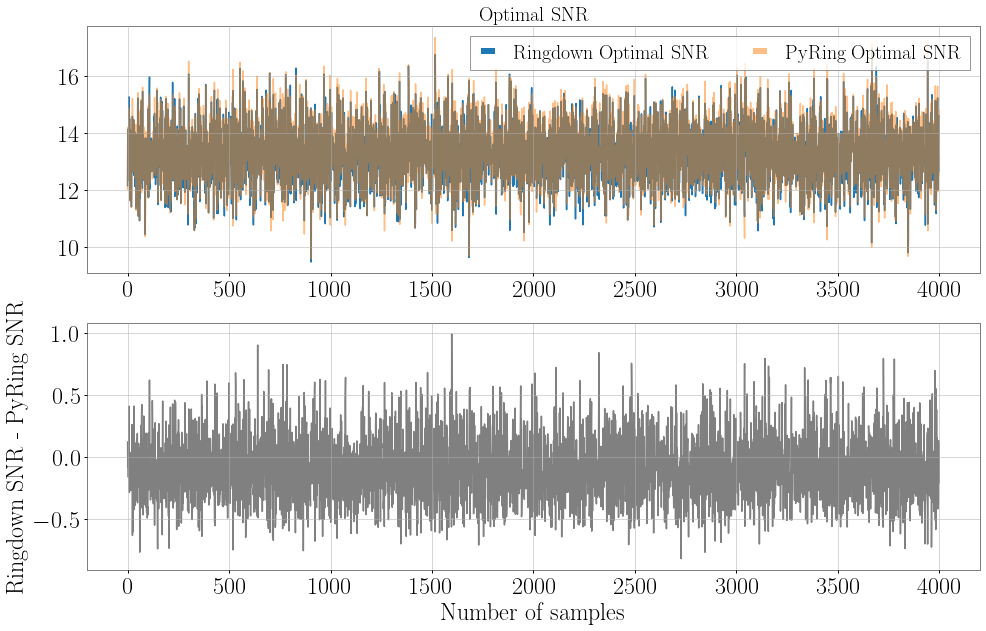

In [31]:
wheel.plotsnr(rd_optsnr,pr_optsnr_net,snr='Optimal SNR')

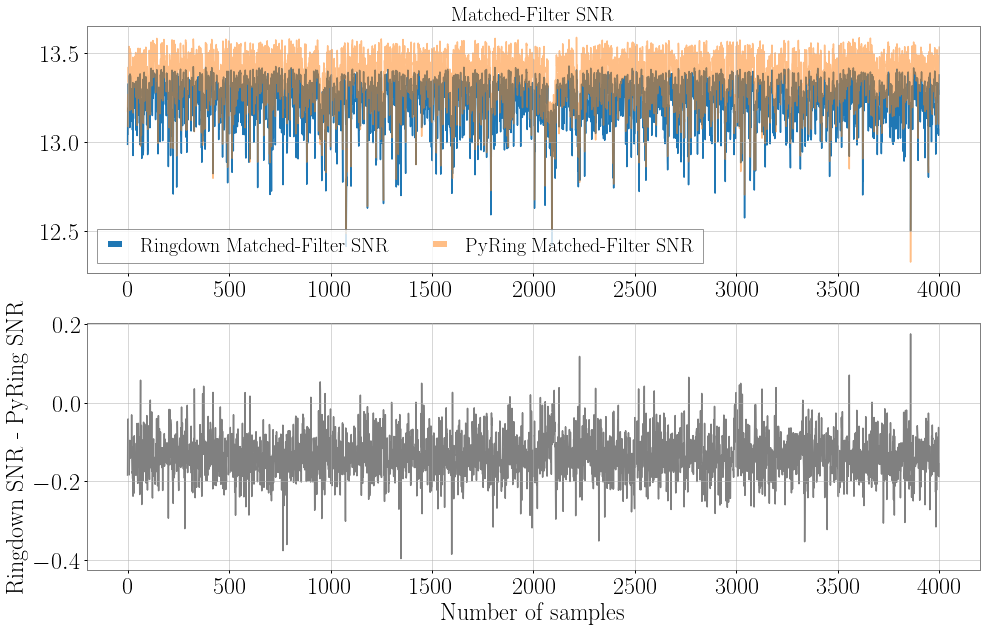

In [32]:
wheel.plotsnr(rd_mfsnr,pr_mfsnr_net,snr='Matched-Filter SNR')

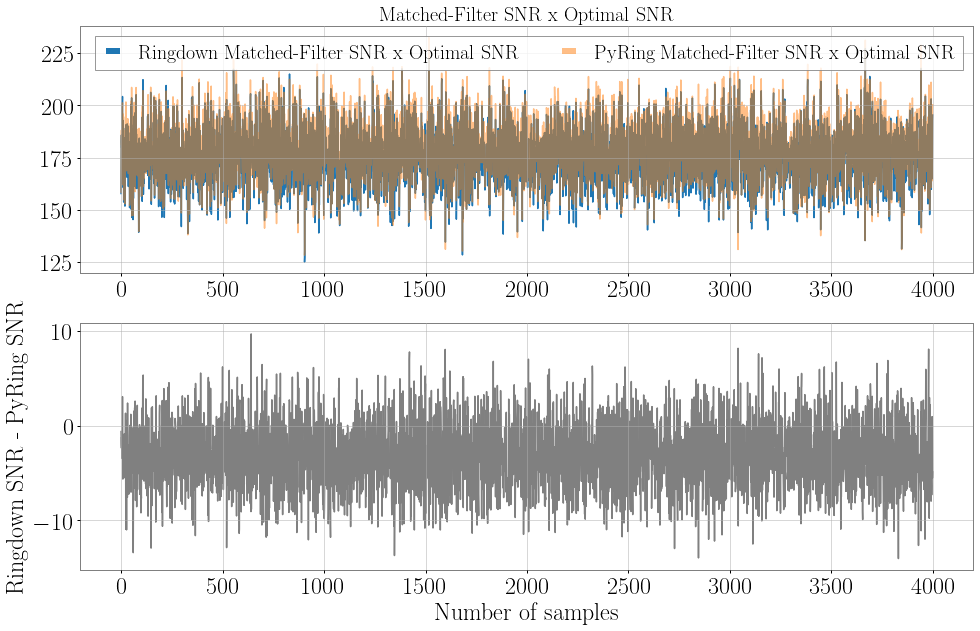

In [33]:
wheel.plotsnr(rd_mfsnr*rd_optsnr,np.array(pr_mfsnr_net)*np.array(pr_optsnr_net),snr='Matched-Filter SNR x Optimal SNR')

# Matched-filter and Optimal SNR from ringdown ACF

In [34]:
importlib.reload(wheel)

<module 'wheel' from '/work/yifan.wang/ringdown/GW150914/pyring/gitlab-ringdown-systematics/utils/wheel.py'>

In [35]:
pr_optsnr_netafr,pr_mfsnr_netafr = wheel.compute_multiple_snr(
    model,pr_time,pr_data,M,chi,A,phi,fit=fit,network=True,acf_from_psd=False,acf_from_ringdown=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [05:08<00:00, 12.95it/s]


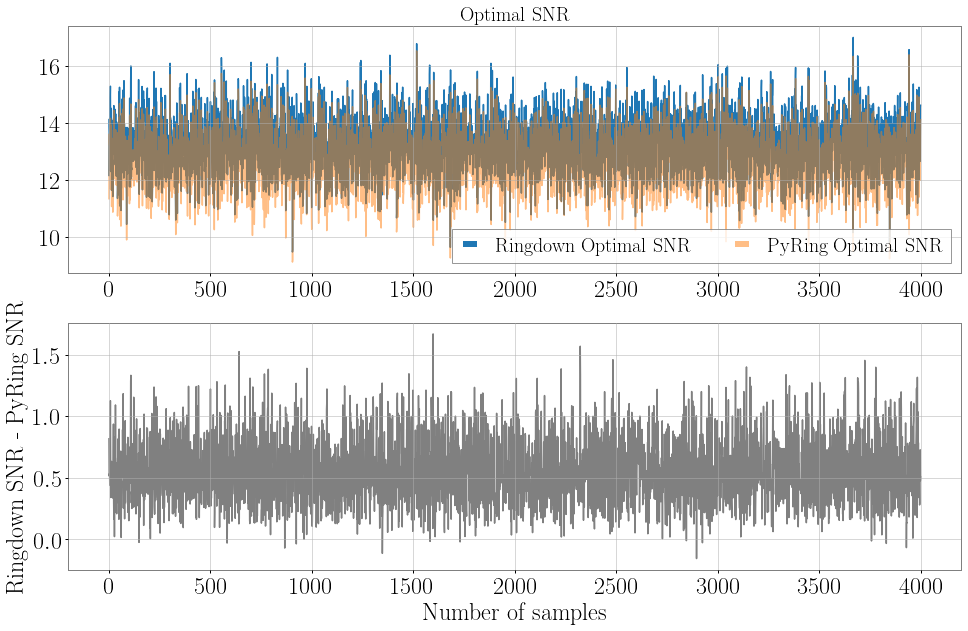

In [36]:
wheel.plotsnr(rd_optsnr,pr_optsnr_netafr,snr='Optimal SNR')

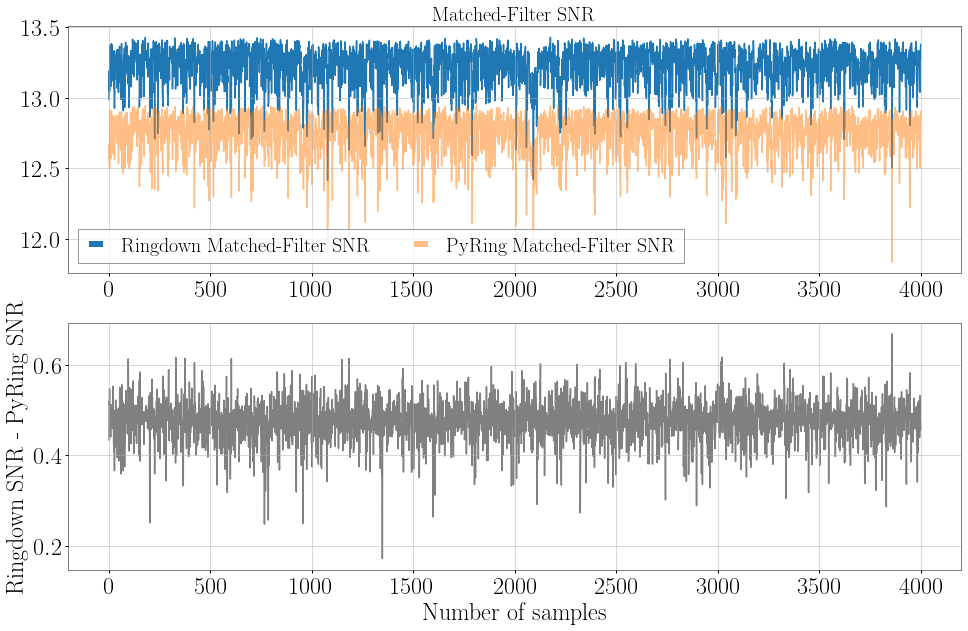

In [37]:
wheel.plotsnr(rd_mfsnr,pr_mfsnr_netafr,snr='Matched-Filter SNR')

Now I think the impact from different ACF is only minor. The PSD is the big issue.

To use Ringdown ACF significantly drops the pyring SNR...

# 07.28: PyCBC analysis

In [38]:
from pycbc.inference import io, models

# Impact of duration on SNR

In [29]:
test_par0p1 = input_par
test_par0p1.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 2048, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*2048),})
model0p1 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par0p1)
pr_data0p1  = {}
pr_time0p1  = {}
for d in model0p1.detectors.keys():
    pr_data0p1[d],pr_time0p1[d] = data.local_load_data(d,**test_par0p1)


Trigtime in H1: 1126259462.423000


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating ACF.
Plancherel theorem E(f)/E(t) (expected value: 1) = 1.0658423561471921

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating

In [30]:
pr_optsnr_net0p1,pr_mfsnr_net0p1 = wheel.compute_multiple_snr(
    model0p1,pr_time0p1,pr_data0p1,M,chi,A,phi,network=True,acf_from_psd=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:17<00:00, 51.92it/s]


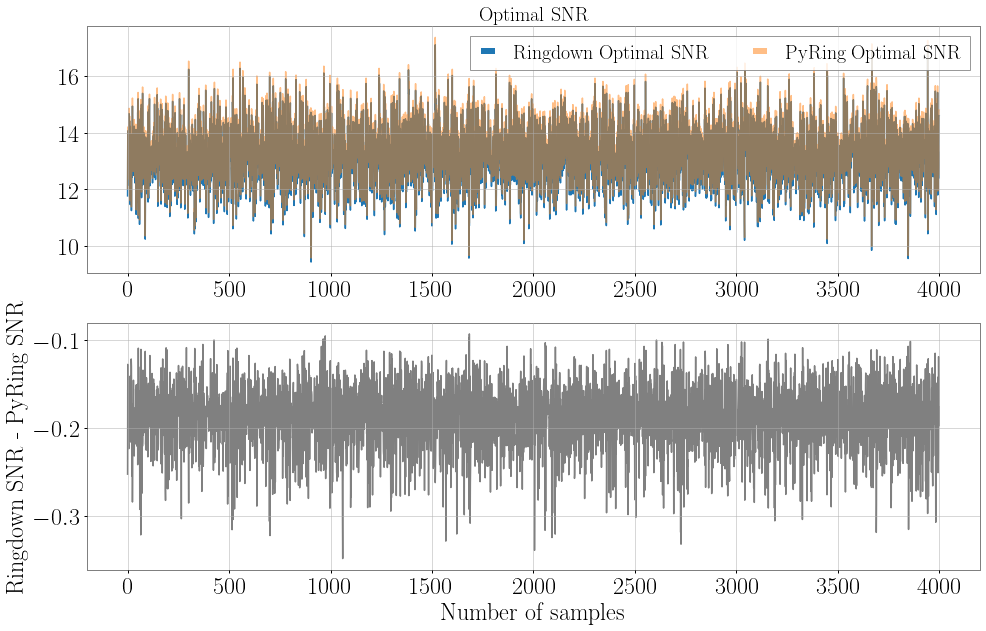

In [31]:
wheel.plotsnr(np.array(pr_optsnr_net0p1),np.array(pr_optsnr_net),snr='Optimal SNR')

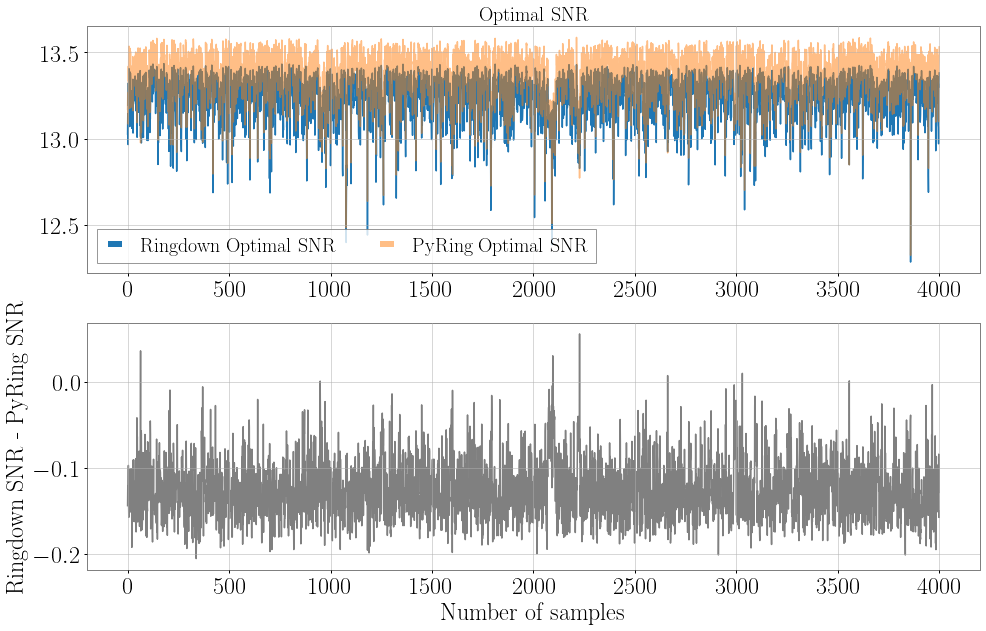

In [32]:
wheel.plotsnr(np.array(pr_mfsnr_net0p1),np.array(pr_mfsnr_net),snr='Optimal SNR')

# 0.4s

In [47]:
test_par0p4 = input_par
test_par0p4.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 2048, 
                'analysis-duration': 0.4, 
                'analysis-duration-n': int(0.4*2048),})
model0p4 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par0p4)
pr_data0p4  = {}
pr_time0p4  = {}
for d in model0p4.detectors.keys():
    pr_data0p4[d],pr_time0p4[d] = data.local_load_data(d,**test_par0p4)


Trigtime in H1: 1126259462.423000


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating ACF.
Plancherel theorem E(f)/E(t) (expected value: 1) = 1.0658423561471921

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating

In [48]:
pr_optsnr_net0p4,pr_mfsnr_net0p4 = wheel.compute_multiple_snr(
    model0p4,pr_time0p4,pr_data0p4,M,chi,A,phi,network=True,acf_from_psd=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [02:58<00:00, 22.42it/s]


# Rank the posteriors according to log posterior

In [33]:
lp = fit.result.sample_stats.lp.stack(samples=('chain','draw'))
lparg = np.argsort(lp.values)

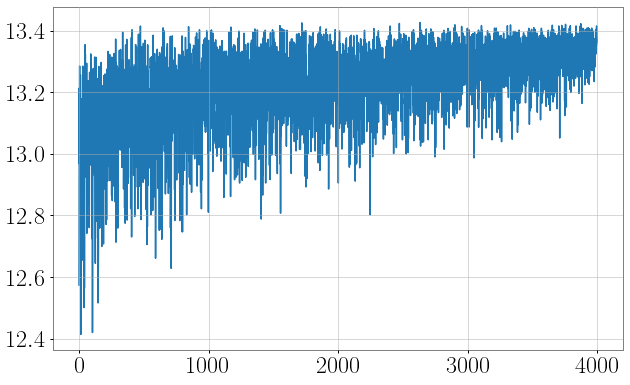

In [34]:
plt.plot(rd_mfsnr[lparg])

In [35]:
pyringloglr = []
for i in tqdm(lparg):
    prefactor = np.sqrt(16*np.pi/5)
    pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}
    pyringloglr.append(model.log_likelihood(pyring_par))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:49<00:00, 80.65it/s]


In [36]:
snr = np.sqrt( 2 * (np.array(pyringloglr) - model.logZnoise))

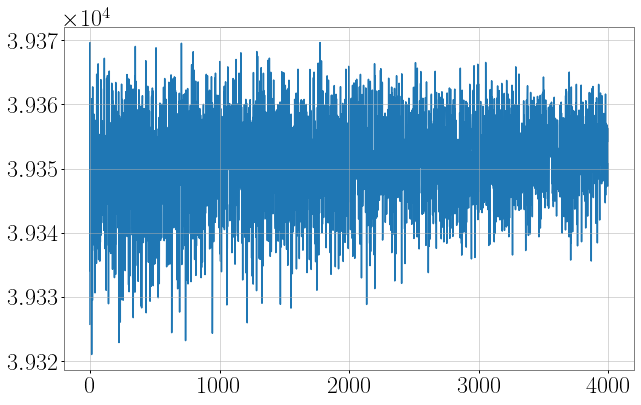

In [37]:
plt.plot(pyringloglr)

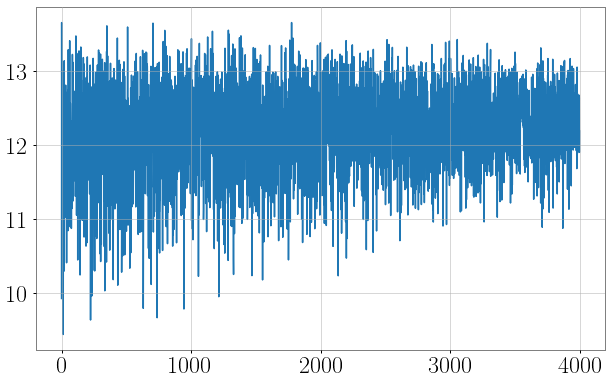

In [38]:
plt.plot(snr)

In [39]:
lparg

array([3040, 1789, 1708, ..., 1564,  439, 1465])

In [40]:
fit.draw_sample(map=True)

(1465,
 Data variables:
     log_drift_unit  (log_drift_unit_dim_0) float64 0.3642 -0.07093
     M               float64 73.17
     chi             float64 0.7367
     cosi            float64 -0.9939
     iota_unit       (iota_unit_dim_0) float64 -0.3248 0.9458
     Ax_unit         (Ax_unit_dim_0) float64 0.2065 0.006218
     Ay_unit         (Ay_unit_dim_0) float64 0.2841 -0.3736
     dts             (dts_dim_0) float64 -5.079e-07
     df              (df_dim_0) float64 0.2558 0.0445
     dtau            (dtau_dim_0) float64 -0.1428 0.1151
     drift           (drift_dim_0) float64 1.0 1.0
     gamma           (gamma_dim_0) float64 219.8 664.0
     f               (f_dim_0) float64 242.9 238.4
     h_det_mode      (h_det_mode_dim_0, h_det_mode_dim_1, h_det_mode_dim_2) float64 ...
     h_det           (h_det_dim_0, h_det_dim_1) float64 1.635e-21 ... 5.686e-41
     A               (A_dim_0) float64 1.756e-21 1.868e-21
     phi             (phi_dim_0) float64 0.9423 -1.554
     tau       

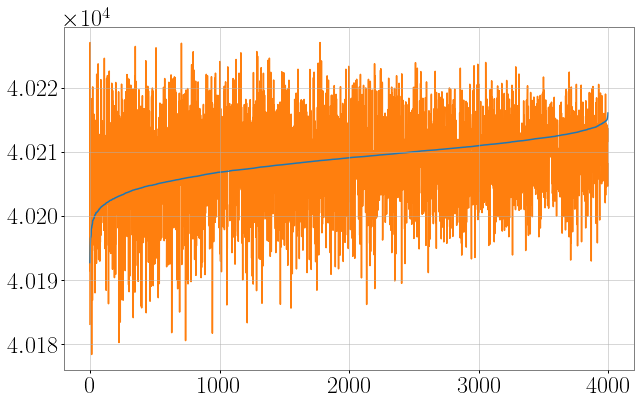

In [41]:
plt.plot(lp[lparg])
plt.plot(np.array(pyringloglr)+(np.median(lp)-np.median(pyringloglr)),zorder=-1)
#plt.plot(np.array(pyringloglr) - model.logZnoise)

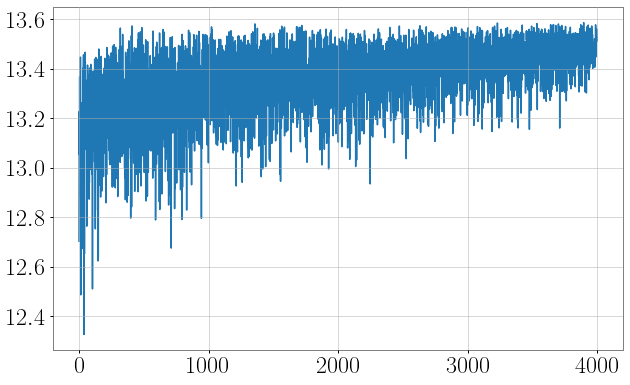

In [42]:
plt.plot(np.array(pr_mfsnr_net)[lparg])

In [43]:
fit0p1 = rd.Fit(model='mchi_aligned')
#fit.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_fit.nc')
for s in raw_strain.values():
    fit0p1.add_data(s)
T = 0.1
srate = 2048
fit0p1.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)

# condition data
fit0p1.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)
fit0p1.compute_acfs()

In [44]:
fit0p1.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_fit.nc')
rd_mfsnr_0p1 = fit0p1.compute_posterior_snrs(optimal=False,network=True)

In [45]:
mfsnrarg = np.argsort(rd_mfsnr)

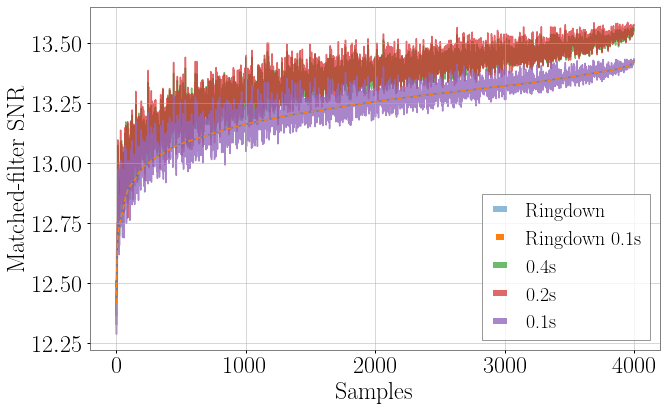

In [56]:
plt.plot(rd_mfsnr[mfsnrarg],label='Ringdown',alpha=0.5,zorder=9)
plt.plot(rd_mfsnr_0p1[mfsnrarg],label='Ringdown 0.1s',ls='--',zorder=9)
plt.plot(np.array(pr_mfsnr_net0p4)[mfsnrarg],alpha=0.7,label='0.4s')
plt.plot(np.array(pr_mfsnr_net)[mfsnrarg],alpha=0.7,label='0.2s')
plt.plot(np.array(pr_mfsnr_net0p1)[mfsnrarg],alpha=0.8,label='0.1s')
plt.ylabel('Matched-filter SNR')
plt.xlabel('Samples')
plt.legend()
plt.savefig('mfsnr.pdf',bbox_inches='tight')

In [ ]:
pr_optsnr_netafp,pr_mfsnr_netafp = wheel.compute_pyring_snr(
    model,M,chi,A,phi,network=True,acf_from_psd=True)

In [ ]:
pr_optsnr_nonet, pr_mfsnr_nonet = pyring_wheel.compute_pyring_snr(
    model,M,chi,A,phi,network=False)

In [ ]:
pyring_wheel.plotsnr(rd_optsnr,pr_optsnr_netafp,snr='Optimal SNR')

In [ ]:
pyring_wheel.plotsnr(rd_mfsnr,pr_mfsnr_netafp,snr='Matched-Filter SNR')

# Plot H1 SNR

In [ ]:
plotsnr(rd_optsnr_nonet[0],pr_optsnr_nonet['H1'],snr='Optimal SNR')

In [ ]:
plotsnr(rd_mfsnr_nonet[0],pr_mfsnr_nonet['H1'],snr='Matched-Filter SNR')

# Plot L1 SNR

In [ ]:
plotsnr(rd_optsnr_nonet[1],pr_optsnr_nonet['L1'],snr='Optimal SNR')

In [ ]:
plotsnr(rd_mfsnr_nonet[1],pr_mfsnr_nonet['L1'],snr='Matched-Filter SNR')

In [ ]:
model.time_delay

# Compute MF SNR for a single sample but with different srate and duration and data conditioning

In [ ]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 4096, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*4096)})
model1 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 4096, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*4096)})
model2 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':512,
                'sampling-rate': 4096, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*4096)})
model3 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 16384, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*16384)})
model4 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

In [ ]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 4096, 
                'analysis-duration': 0.2, 
                'analysis-duration-n': int(0.2*4096)})
model5 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 4096, 
                'analysis-duration': 0.4, 
                'analysis-duration-n': int(0.4*4096)})
model6 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

In [ ]:
pr1 = pyring_wheel(model1)
pr1.mfsnr(pyring_par)

In [ ]:
pr2 = pyring_wheel(model2)
pr2.mfsnr(pyring_par)

In [ ]:
pr3 = pyring_wheel(model3)
pr3.mfsnr(pyring_par)

In [ ]:
pr4 = pyring_wheel(model4)
pr4.mfsnr(pyring_par)

In [ ]:
pr5 = pyring_wheel(model5)
pr5.mfsnr(pyring_par)

In [ ]:
pr6 = pyring_wheel(model6)
pr6.mfsnr(pyring_par)

# How about 8192 Hz

In [ ]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 8192, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*8192)})
model11 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

In [ ]:
pr11 = pyring_wheel(model11)
pr11.mfsnr(pyring_par)

In [ ]:
pyring_par

# Plot the waveforms

In [ ]:
for i in range(1):
    prefactor = np.sqrt(16*np.pi/5)
    pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}
    
    result = pyring_wheel(model,pyring_par)
    plt.figure(figsize=[16,10])
    
    plt.plot(model.tevent+time_array['H1']+dt['H1'],result.hstrain['H1'],ls='--',marker='o',ms=5,label='pyring H1')
    plt.plot(fit.analysis_data['H1'].index,hs[0,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='ringdown h_det H1')
    
    plt.plot(model.tevent+time_array['L1']+dt['L1'],result.hstrain['L1'],ls='--',marker='o',ms=5,label='pyring L1')
    plt.plot(fit.analysis_data['L1'].index,hs[1,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='ringdown h_det L1')
    
    plt.xlim(fit.analysis_data['H1'].index[0]-0.02,fit.analysis_data['H1'].index[0]+0.05)
    plt.legend(loc='best')

In [ ]:
fit.analysis_data['H1'].index[0]

# Evidence that maybe the data conditioning make the difference here

PyRing data conditioning: 

Band pass: [20,1014] Hz

sampling rate: 2048 Hz

In [ ]:
fit.analysis_data

In [ ]:
plt.hist(A[1][:].values*prefactor/1e-21,bins=np.linspace(0,50,100),density=True)
plt.axhline(0.02,ls='--')